<a href="https://colab.research.google.com/github/maximmillion/TitanicSurvival/blob/master/TitanticLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0.7765151
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprmbndwsr/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


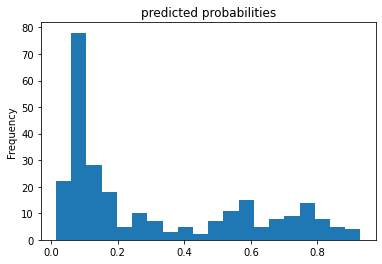

In [17]:
!pip install -q sklearn
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# training data
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') 
# testing data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') 
dftrain.head()

# we want to predict survived
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

 # gets a list of all unique values from given feature column
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique() 
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# input function
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
   # inner function, this will be returned
  def input_function(): 
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) 
    if shuffle:
      ds = ds.shuffle(1000)  
    ds = ds.batch(batch_size).repeat(num_epochs)  
    return ds  
  return input_function  
train_input_fn = make_input_fn(dftrain, y_train)  
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

# train
linear_est.train(train_input_fn)  

# get model metrics/stats by testing on tetsing data
result = linear_est.evaluate(eval_input_fn)  

clear_output()  
print(result['accuracy'])  

pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
